## Notebook Overview: Failed Statistical Analysis of Wind Influence on Mixed Layer Depth (MLD)

This notebook explores whether short-term wind conditions significantly influence mixed layer depth (MLD) in Stagecoach Reservoir. Using several statistical modeling approaches—including plain OLS, bootstrap resampling, and mixed-effects models—it evaluates the relationship between wind metrics and MLD.

### Objectives:
- **Aggregate wind data** over 6, 12, and 24-hour windows leading up to CTD casts.
- **Perform plain OLS regression** on all dock data pooled together to assess general trends.
- **Validate trends with bootstrap** resampling to estimate confidence intervals.
- **Use mixed-effects models** with calendar day as a random intercept to explore within-day variance.
- **Interpret model statistics** including slope, R², p-values, and residual variance.

---

### Summary of Findings

Despite expectations, **no significant linear relationship** was found between wind metrics and MLD:

#### 1. **Plain OLS Results**
- All wind predictors yielded **low R² values (< 0.03)**.
- 95% confidence intervals for slope estimates all **cross zero**, showing **no statistically significant trend**.
- Example: 24-hour mean wind had a slope of +0.35 m per m s⁻¹ but a p-value of 0.36 and a wide CI of –0.41 to +1.12.

#### 2. **Bootstrap Resampling**
- 4000 resamples confirmed uncertainty: all slope confidence intervals still crossed zero.
- Example: 24 h window → mean slope = +0.33 m, CI = –0.29 … +0.79 m.

#### 3. **Mixed-Effects Models**
- Even after centering predictors and using calendar day as a random intercept:
  - Slopes remained non-significant.
  - Residual variance explained by day-to-day differences was ≤ 4%.
  - In some cases (e.g., uncentered 12 h window), fits became **numerically unstable**.

---

### Why the Models Failed

1. **Small Sample Size**: Only 49 casts over 7 days (~7 per regression), severely limiting statistical power.
2. **Narrow Wind Range**: Wind values ranged just 0.5–4 m s⁻¹, giving limited leverage on slope estimation.
3. **High Noise**: Residual standard deviation (1.7–1.9 m) far exceeds the average slope (~0.3 m), burying any signal.
4. **Temporal Mismatch**: With only 3 casts per day, sub-daily mixing events likely went undetected.


In [ ]:
# . . . . Import Packages
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, pytz
from scipy.stats import pearsonr


Dock_1
  6h:  r =  0.320,   p =  0.245
  12h:  r =  0.342,   p =  0.212
  24h:  r =  0.220,   p =  0.432

Dock_2
  6h:  r = -0.116,   p =  0.648
  12h:  r = -0.104,   p =  0.68
  24h:  r =  0.169,   p =  0.503

Dock_3
  6h:  r =  0.158,   p =  0.558
  12h:  r =  0.213,   p =  0.428
  24h:  r =  0.036,   p =  0.895


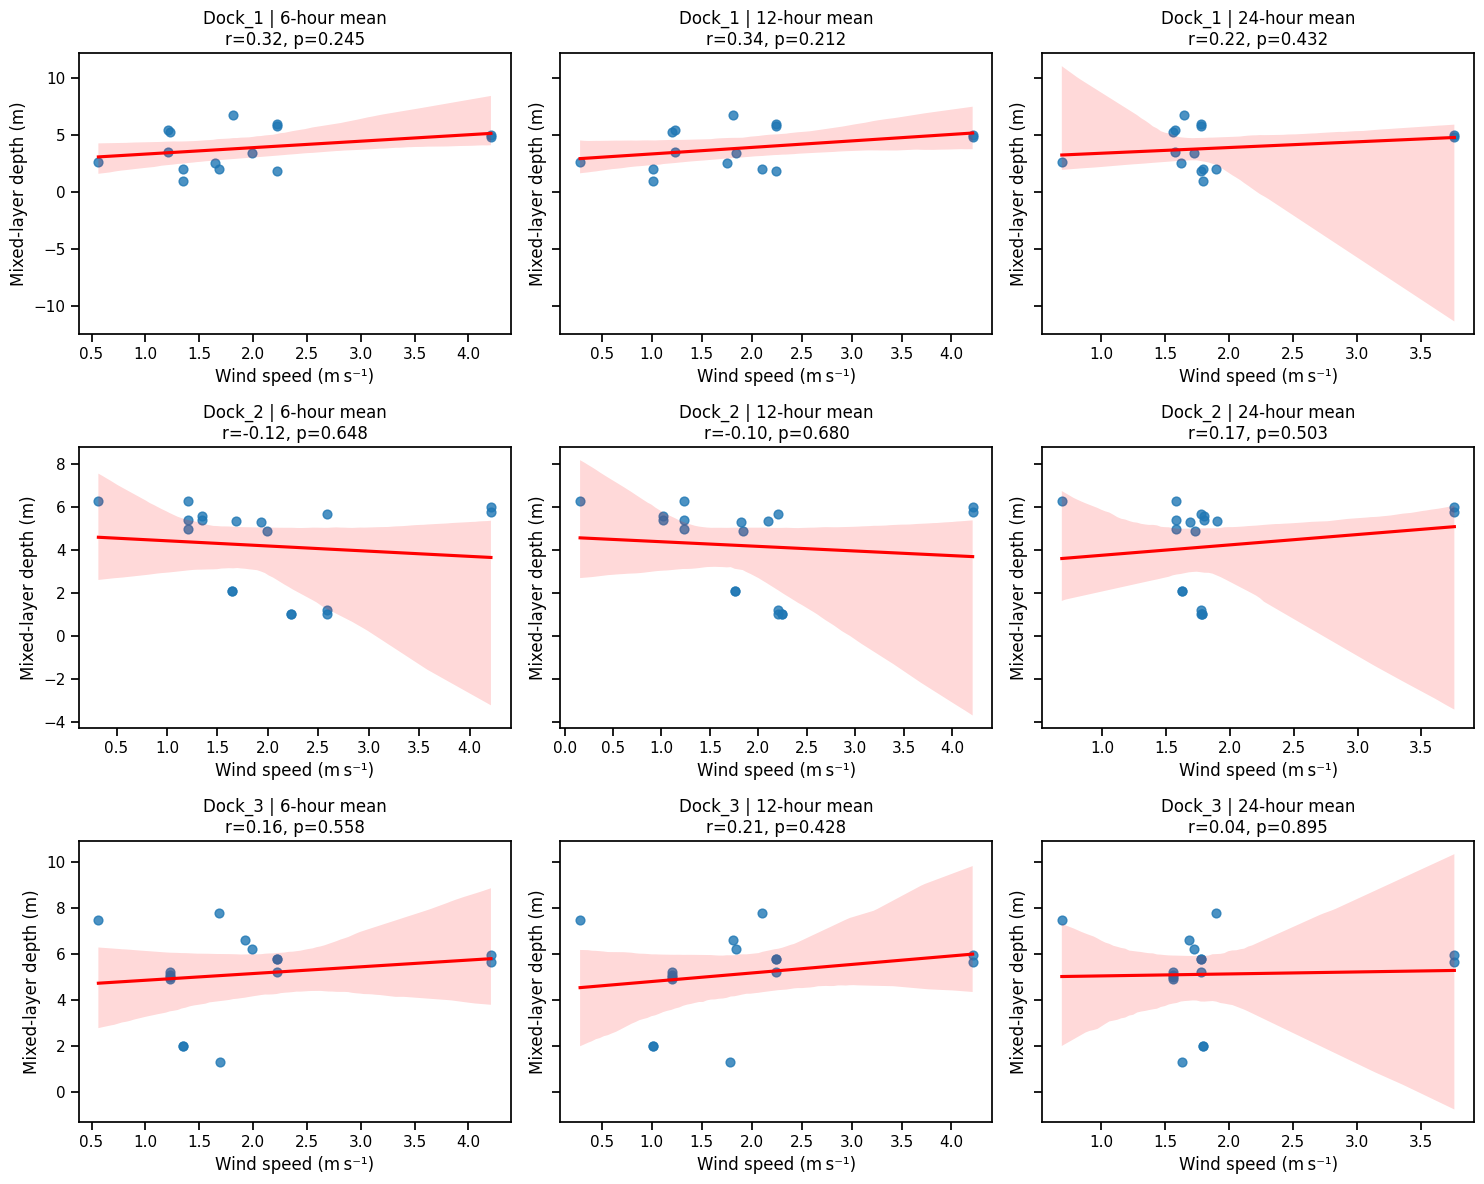

In [ ]:
#  Load & clean datasets
WFILE = '/content/drive/MyDrive/Field_Camp /correlation/C3SKI.2025-05-28.csv'

wx = (pd.read_csv(WFILE, comment='#')                # ignore all lines that start with ‘#’
        .dropna(subset=['Date_Time'])                # remove the units row
        .assign(Date_Time=lambda d:
                pd.to_datetime(d['Date_Time'], utc=True))
        .rename(columns={'wind_speed_set_1': 'wind_speed'})
        .assign(datetime=lambda d: d['Date_Time'].dt.tz_convert(None))  # naïve‑UTC
        [['datetime', 'wind_speed']]
        .astype({'wind_speed': 'float64'})            # force numeric
      )

DFILE = '/content/drive/MyDrive/Field_Camp /correlation/dock_casts_with_mld_patched.csv'

mountain = pytz.timezone('America/Denver')            # local time for Steamboat Springs

dock = (pd.read_csv(DFILE)
          .rename(columns={'Cast time (local)': 'cast_local',
                           'Dock Location'     : 'dock_location',
                           'MLD'               : 'mld'})
          .assign(cast_local=lambda d: pd.to_datetime(d['cast_local'], errors='coerce'))
          .dropna(subset=['cast_local'])
          .assign(datetime_utc=lambda d:
                  d['cast_local'].dt.tz_localize(mountain)
                                   .dt.tz_convert('UTC')
                                   .dt.tz_localize(None))
          [['datetime_utc', 'dock_location', 'mld']]
          .astype({'mld': 'float64'})
       )

# mean wind speed in the N‑h window immediately before a cast
def window_means(wx, t, hours):
    window = wx.loc[(wx['datetime'] > t - pd.Timedelta(hours=hours)) &
                    (wx['datetime'] <= t), 'wind_speed']
    return window.mean()

# build one row per cast with 6 / 12 / 24 h wind means
records = []
for t, loc, mld in dock.itertuples(index=False):
    rec = {'datetime' : t,
           'dock_location': loc,
           'mld'  : mld,
           'wind_6h' : window_means(wx, t,  6),
           'wind_12h': window_means(wx, t, 12),
           'wind_24h': window_means(wx, t, 24)}
    records.append(rec)

df = (pd.DataFrame(records)
        .drop_duplicates(['datetime', 'dock_location']))   # one point per cast

# correlations
corr = {}
for dock_id, g in df.groupby('dock_location'):
    corr[dock_id] = {f'{w}h': pearsonr(g['mld'], g[f'wind_{w}h'])
                     for w in [6,12,24]}

# pretty‑print
for d, vals in corr.items():
    print(f'\n{d}')
    for w, (r, p) in vals.items():
        print(f'  {w}:  r = {r: .3f},   p = {p: .3g}')

# scatter + trend‑line plots
sns.set_context('notebook')
fig, axes = plt.subplots(df['dock_location'].nunique(), 3,
                         figsize=(15, 4*df['dock_location'].nunique()),
                         sharey='row')
if axes.ndim == 1: axes = axes.reshape(1,-1)          # handle single‑dock case

for (dock_id, g), row in zip(df.groupby('dock_location'), axes):
    for ax, w in zip(row, [6,12,24]):
        sns.regplot(data=g, x=f'wind_{w}h', y='mld',
                    ax=ax, scatter_kws=dict(s=40), line_kws=dict(color='red'))
        r, p = corr[dock_id][f'{w}h']
        ax.set_title(f'{dock_id} | {w}‑hour mean\nr={r:.2f}, p={p:.3f}')
        ax.set_xlabel('Wind speed (m s⁻¹)')
        ax.set_ylabel('Mixed‑layer depth (m)')
plt.tight_layout()

In [ ]:
# DAILY correlations

mountain = pytz.timezone('America/Denver')

df['local_date'] = (pd.to_datetime(df['datetime'], utc=True)
                      .dt.tz_convert(mountain)
                      .dt.date)

# Compute r & p for every (dock, date)
daily_records = []
for (dock_id, day), grp in df.groupby(['dock_location', 'local_date']):
    rec = {'dock_location': dock_id, 'date': day}
    for w in (6, 12, 24):
        col = f'wind_{w}h'
        if grp[col].count() >= 3:                        # need ≥3 points for Pearson
            r, p = pearsonr(grp['mld'], grp[col])
        else:                                            # not enough data for that cell
            r, p = np.nan, np.nan
        rec[f'r_{w}h'] = r
        rec[f'p_{w}h'] = p
    daily_records.append(rec)

daily_corr = pd.DataFrame(daily_records)
daily_corr.sort_values(['dock_location', 'date'], inplace=True)
display(daily_corr.head(10))

<ipython-input-3-f0df19e6dbef>:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(grp['mld'], grp[col])


,dock_location,date,r_6h,p_6h,r_12h,p_12h,r_24h,p_24h
0,Dock_1,2025-05-13,NaN,NaN,NaN,NaN,NaN,NaN
1,Dock_1,2025-05-14,NaN,NaN,NaN,NaN,NaN,NaN
2,Dock_1,2025-05-15,0.179252,0.885264,0.409956,0.731088,-0.088586,0.943530
3,Dock_1,2025-05-16,0.458957,0.696446,-0.458957,0.696446,-0.458957,0.696446
4,Dock_1,2025-05-17,NaN,NaN,NaN,NaN,NaN,NaN
5,Dock_1,2025-05-18,NaN,NaN,NaN,NaN,NaN,NaN
6,Dock_1,2025-05-19,NaN,NaN,NaN,NaN,NaN,NaN
7,Dock_2,2025-05-13,NaN,NaN,NaN,NaN,NaN,NaN
8,Dock_2,2025-05-14,NaN,NaN,NaN,NaN,NaN,NaN
9,Dock_2,2025-05-15,0.971330,0.028670,0.953403,0.046597,0.896120,0.103880


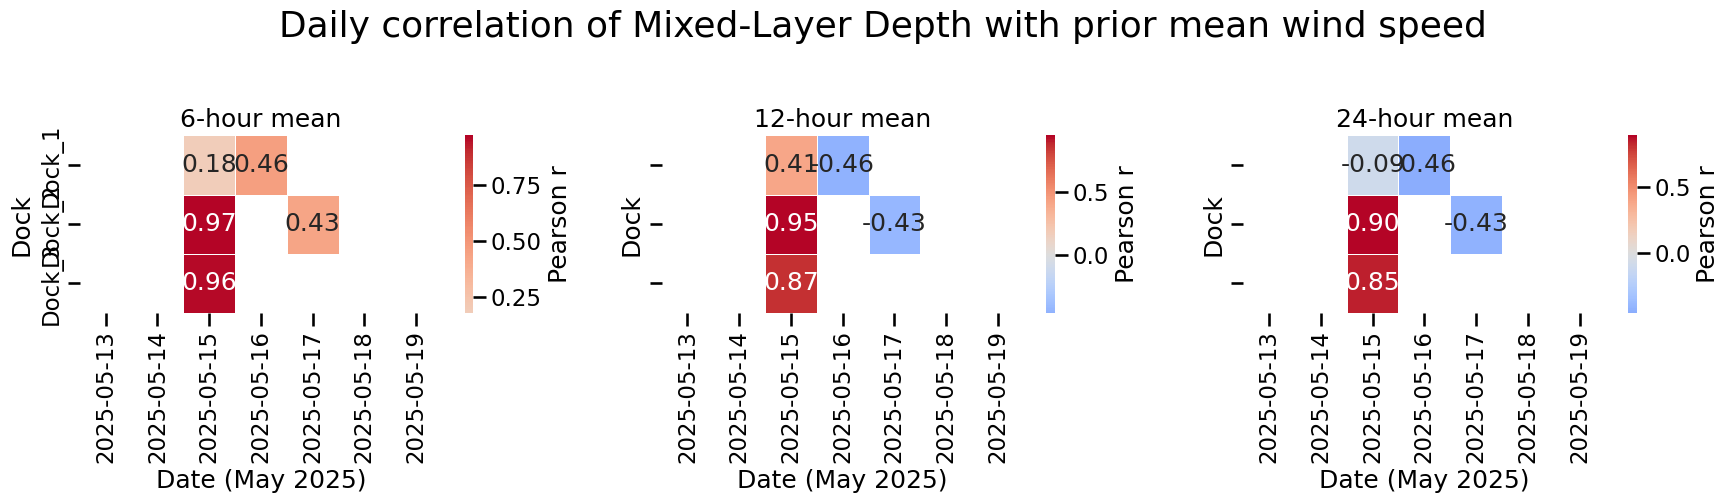

In [ ]:
# visual summary as heat‑maps
import matplotlib as mpl
sns.set_context('talk')
windows = (6, 12, 24)
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, w in zip(axs, windows):
    pivot = (daily_corr
             .pivot(index='dock_location', columns='date', values=f'r_{w}h')
             .reindex(index=sorted(df['dock_location'].unique())))
    sns.heatmap(pivot, cmap='coolwarm', center=0, annot=True, fmt='.2f',
                linewidths=.5, ax=ax, cbar_kws={'label': 'Pearson r'})
    ax.set_title(f'{w}-hour mean')
    ax.set_xlabel('Date (May 2025)')
    ax.set_ylabel('Dock')

plt.suptitle('Daily correlation of Mixed‑Layer Depth with prior mean wind speed',
             y=1.02, fontsize='x-large')
plt.tight_layout()

In [ ]:
# Pooled‑strength analysis with a linear mixed‑effects model

import statsmodels.formula.api as smf

def fit_mixed(window_hrs=12):
    """
    Fit mld  ~  beta0_day  +  beta1 * wind_{window}
    where beta0_day is a random intercept drawn separately for each calendar date.

    Parameters
    ----------
    window_hrs : int  {6, 12, 24}
        Which wind‑speed window to use.

    Returns
    -------
    statsmodels MixedLMResults
    """
    col = f'wind_{window_hrs}h'
    # drop NaNs that can arise if no weather data in that window
    dsub = df[[col, 'mld', 'local_date']].dropna()

    model  = smf.mixedlm(f"mld ~ {col}", data=dsub, groups="local_date")
    result = model.fit(method='lbfgs', reml=False)

    print(f"\n=== Mixed‑Effects Model for {window_hrs}‑hour wind mean ===")
    print(result.summary())
    return result

# Centre the predictor
df['wind_12h_c'] = df['wind_12h'] - df['wind_12h'].mean()

# Re‑fit with centred wind and a random intercept per day
m12c = smf.mixedlm("mld ~ wind_12h_c", data=df, groups="local_date").fit()

print(m12c.summary())

# Fit models for the three windows:
res6  = fit_mixed(6)
res12 = fit_mixed(12)
res24 = fit_mixed(24)

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: mld      
No. Observations:  49      Method:             REML     
No. Groups:        7       Scale:              3.5810   
Min. group size:   3       Log-Likelihood:     -102.1002
Max. group size:   11      Converged:          Yes      
Mean group size:   7.0                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.456    0.386 11.552 0.000  3.700  5.212
wind_12h_c     0.238    0.347  0.686 0.493 -0.443  0.919
local_date Var 0.452    0.351                           


=== Mixed‑Effects Model for 6‑hour wind mean ===
                  Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        mld   
No. Observations:         49             Method:                    ML    
No. Groups: 

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/d

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mld      
No. Observations: 49      Method:             ML       
No. Groups:       7       Scale:              3.5924   
Min. group size:  3       Log-Likelihood:     -101.7239
Max. group size:  11      Converged:          Yes      
Mean group size:  7.0                                  
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      3.774    0.841 4.486 0.000  2.125  5.423
wind_24h       0.339    0.406 0.833 0.405 -0.458  1.135
local_date Var 0.147    0.205                          



In [ ]:
# ➊ Centre the predictor
df['wind_12h_c'] = df['wind_12h'] - df['wind_12h'].mean()

# ➋ Re‑fit with centred wind and a random intercept per day
m12c = smf.mixedlm("mld ~ wind_12h_c", data=df, groups="local_date").fit()

print(m12c.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: mld      
No. Observations:  49      Method:             REML     
No. Groups:        7       Scale:              3.5810   
Min. group size:   3       Log-Likelihood:     -102.1002
Max. group size:   11      Converged:          Yes      
Mean group size:   7.0                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      4.456    0.386 11.552 0.000  3.700  5.212
wind_12h_c     0.238    0.347  0.686 0.493 -0.443  0.919
local_date Var 0.452    0.351                           



In [ ]:
import statsmodels.api as sm

def pooled_ols(window):
    col = f'wind_{window}h'
    dsub = df[[col, 'mld']].dropna()
    X = sm.add_constant(dsub[col])     # intercept + slope
    ols = sm.OLS(dsub['mld'], X).fit()
    print(f"\nOLS for {window}-hour mean")
    print(ols.summary())
    return ols

ols6  = pooled_ols(6)
ols12 = pooled_ols(12)
ols24 = pooled_ols(24)


OLS for 6-hour mean
                            OLS Regression Results                            
Dep. Variable:                    mld   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.3643
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.549
Time:                        02:05:41   Log-Likelihood:                -102.08
No. Observations:                  49   AIC:                             208.2
Df Residuals:                      47   BIC:                             211.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0528      0.63

In [ ]:
from numpy.random import default_rng
from scipy.stats   import pearsonr

rng, reps = default_rng(42), 4000
def boot_slope(window):
    col = f'wind_{window}h'
    dsub = df[[col, 'mld']].dropna().to_numpy()
    slopes = []
    for _ in range(reps):
        samp = dsub[rng.integers(len(dsub), size=len(dsub))]
        X, y = samp[:,0], samp[:,1]
        beta1 = np.cov(X, y, bias=True)[0,1] / np.var(X, ddof=0)
        slopes.append(beta1)
    lo, hi = np.percentile(slopes, [2.5, 97.5])
    print(f"{window}‑h  boot‑slope = {np.mean(slopes):.2f}  (95 % CI {lo:.2f} … {hi:.2f})")

boot_slope(6)
boot_slope(12)
boot_slope(24)

6‑h  boot‑slope = 0.15  (95 % CI -0.38 … 0.56)
12‑h  boot‑slope = 0.22  (95 % CI -0.26 … 0.62)
24‑h  boot‑slope = 0.33  (95 % CI -0.29 … 0.79)


In [ ]:
rho_air = 1.225        # kg m‑3
Cd      = 1.3e-3
df['tau24'] = rho_air * Cd * df['wind_24h']**2            # N m‑2
df['log_tau24'] = np.log(df['tau24'])

X = sm.add_constant(df['log_tau24'])
phys = sm.OLS(df['mld'], X, missing='drop').fit()
print(phys.summary())

X = sm.add_constant(df['log_tau24'])
phys = sm.OLS(df['mld'], X, missing='drop').fit()
print(phys.summary())

                            OLS Regression Results                            
Dep. Variable:                    mld   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.1186
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.732
Time:                        02:06:00   Log-Likelihood:                -102.21
No. Observations:                  49   AIC:                             208.4
Df Residuals:                      47   BIC:                             212.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1185      2.121      2.413      0.0